In [1]:
import tensorflow as tf
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data= pd.read_csv('/content/drive/MyDrive/train-1.csv')
data.head()

metaphorID  label                                               text
0           0   True  Hey , Karen !!!! I was told that on the day of...
1           2  False  Hi Ladies ... my last chemo was Feb 17/09 , ra...
2           2  False  I have just come form my consult with a lovely...
3           4  False  I also still question taking Tamox for stage 1...
4           2  False  Just checking in to say hello ladies . I had a...

In [4]:
data['label']=data['label'].astype(int)
data.head()

metaphorID  label                                               text
0           0      1  Hey , Karen !!!! I was told that on the day of...
1           2      0  Hi Ladies ... my last chemo was Feb 17/09 , ra...
2           2      0  I have just come form my consult with a lovely...
3           4      0  I also still question taking Tamox for stage 1...
4           2      0  Just checking in to say hello ladies . I had a...

In [5]:
import re
import spacy
nlp = spacy.load('en_core_web_sm')

# Function for text preprocessing and lemmatization
def preprocess_and_lemmatize(text):
    text = text.lower()
    text = re.sub(r'\?+', '?', text)
    text = re.sub(r'\!+', '!', text)
    text = re.sub(r'\/+', '', text)
    text = re.sub(r'`', '', text)
    text = re.sub(r'-lrb-', '-', text)
    text = re.sub(r'-rrb-', '-', text)
    text = re.sub(r'\-+', '-', text)
    # text = re.sub(r"\b(i['`’]ve|i['`’]m|i['`’]ll)\b", lambda m: m.group(0).replace("'", " "), text)
    text = re.sub(
    r"\b(i['’]ve|i['’]m|i['’]ll)\b",
    lambda m: {
        "i've": "I have",
        "i’m": "I am",
        "i'm": "I am",
        "i’ll": "I will",
        "i'll": "I will"
    }[m.group(0).lower()],
    text,
    flags=re.IGNORECASE
)
    text = re.sub(r" - ", " . ", text)

    doc = nlp(text)
    lemmatized_tokens = [token.lemma_ for token in doc]
    lemmatized_text = ' '.join(lemmatized_tokens)
    lemmatized_text = re.sub(r"'s\b", "s", lemmatized_text)
    return lemmatized_text

# Visualizing WordClouds according to Metaphor IDs (on RAW data)

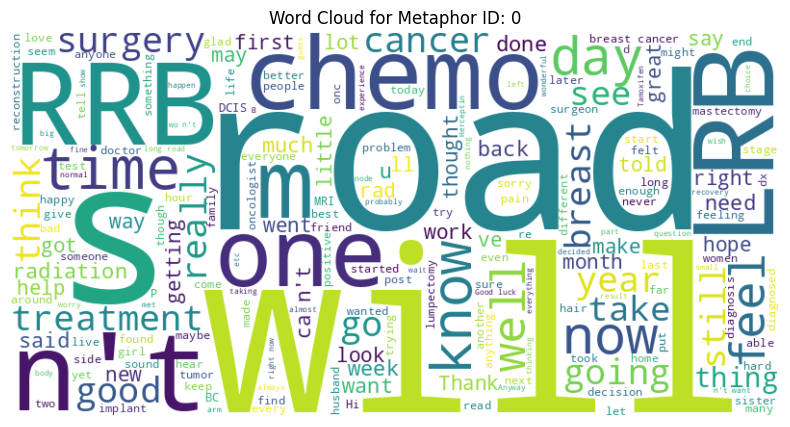

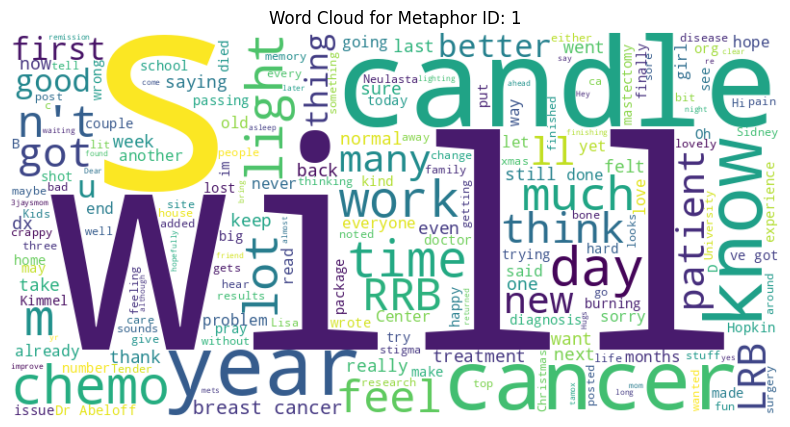

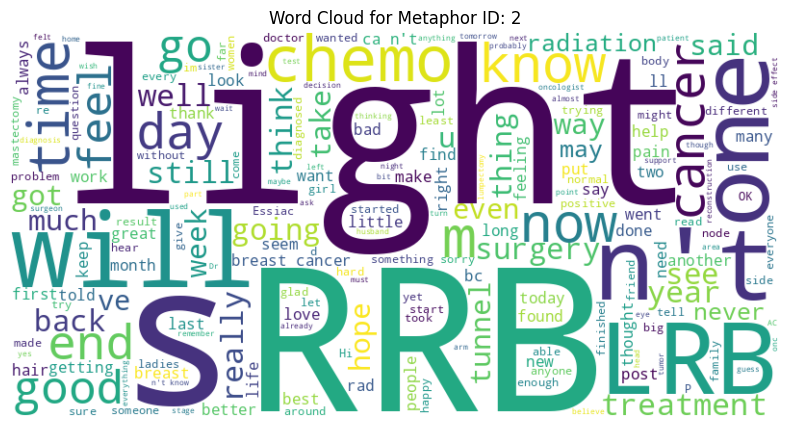

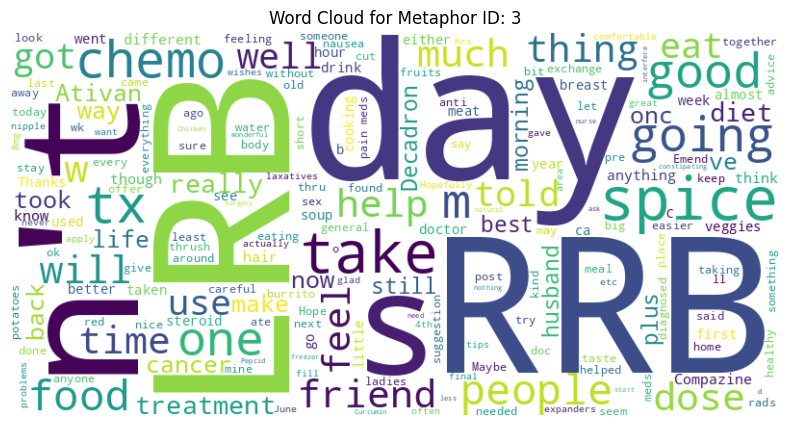

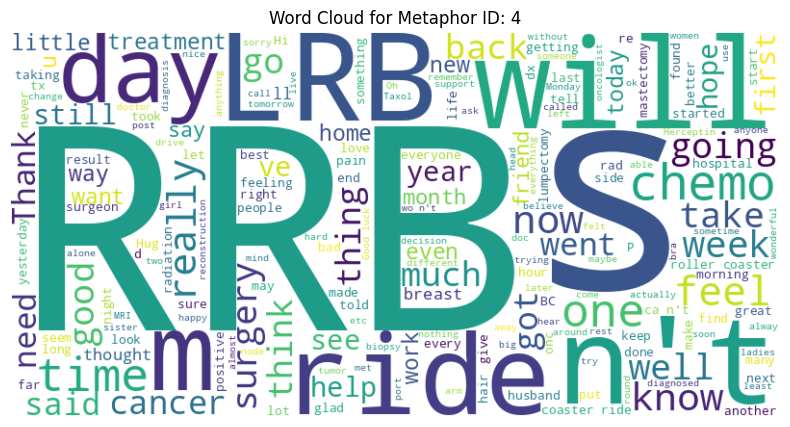

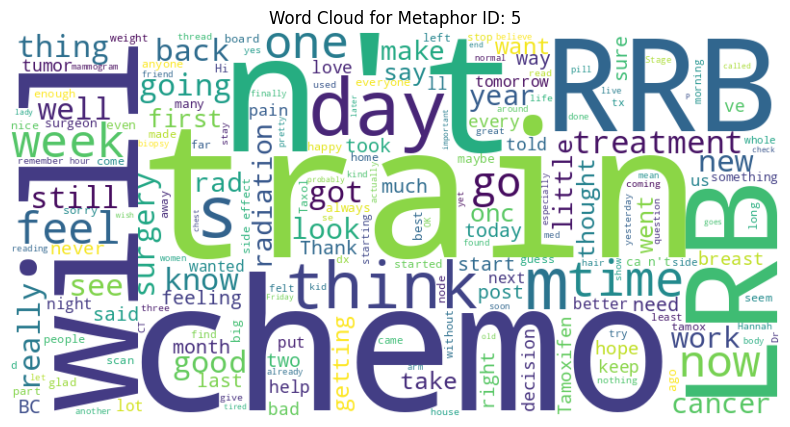

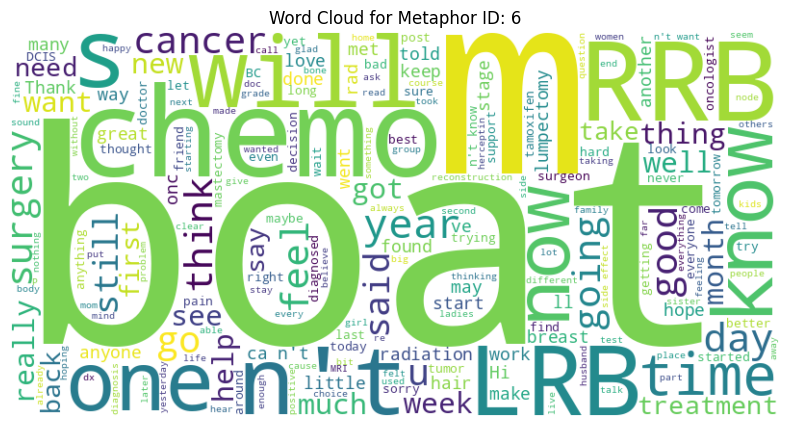

In [6]:
# Lets plot a word cloud of all the text according to metaphorID

# Import necessary libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Group the data by metaphorID
grouped_data = data.groupby('metaphorID')['text'].apply(lambda x: ' '.join(x))

# Loop through each metaphorID and generate a word cloud
for metaphor_id, text in grouped_data.items():
    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Display the generated image:
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for Metaphor ID: {metaphor_id}")
    plt.show()

In [7]:
metaphor_keywords = {
    0: 'road',
    1: 'candle',
    2: 'light',
    3: 'spice',
    4: 'ride',
    5: 'train',
    6: 'boat'
}

In [8]:
# Function to extract metaphor-related sentences
def extract_metaphor_sentences(df):
    imp_text = []

    for _, row in df.iterrows():
        metaphor_keyword = metaphor_keywords.get(row['metaphorID'], '')
        selected_sentence = ""

        for sentence in row['lemmatized_text'].split('.'):
            if metaphor_keyword in sentence:
                # Break condition: prioritize sentences without specific punctuation
                if not any(punct in sentence for punct in [' - ', ' , ', ' ; ', ' ? ', ' ! ']):
                    selected_sentence = sentence
                    break

                # Secondary prioritization based on punctuation
                for punct in [' , ', ' ; ', ' ? ', ' ! ', ' - ']:
                    if punct in sentence:
                        for sub_sentence in sentence.split(punct):
                            if metaphor_keyword in sub_sentence:
                                selected_sentence = sub_sentence
                                break
                        if selected_sentence:
                            break

        if selected_sentence:
            imp_text.append(selected_sentence)

    return imp_text

In [9]:
def final_preprocess_data(df):

    # Preprocess and lemmatize text
    df['lemmatized_text'] = df['text'].apply(preprocess_and_lemmatize)

    # Extract metaphor-related sentences
    imp_text = extract_metaphor_sentences(df)

    # Create cleaned DataFrame with important metaphor-related sentences
    cleaned_df = pd.DataFrame({'text': imp_text})
    cleaned_df[["metaphorID", "label"]] = df.iloc[:, :2]
    print(cleaned_df.head())
    # Map labels to target binary values
    cleaned_df["target"] = cleaned_df["label"].map({True: 1, False: 0})
    cleaned_df = cleaned_df.drop("label", axis=1)

    # Map metaphorID to metaphor keywords
    cleaned_df["metaphor"] = cleaned_df["metaphorID"].map(metaphor_keywords)
    cleaned_df = cleaned_df.drop("metaphorID", axis=1)

    return cleaned_df

In [10]:
cleaned_df = final_preprocess_data(data)

                                                text  metaphorID  label
0                         just a gliche in the road            0      1
1  be any of you have problem with feel light hea...           2      0
2                                light on the tonic            2      0
3   be not the rad to get ride of any stray cance...           4      0
4                              light be on the tree            2      0


In [11]:
cleaned_df.head()

text  target metaphor
0                         just a gliche in the road      NaN     road
1  be any of you have problem with feel light hea...     NaN    light
2                                light on the tonic      NaN    light
3   be not the rad to get ride of any stray cance...     NaN     ride
4                              light be on the tree      NaN    light

# Visualizing WordClouds according to Metaphor IDs (on CLEAN data)

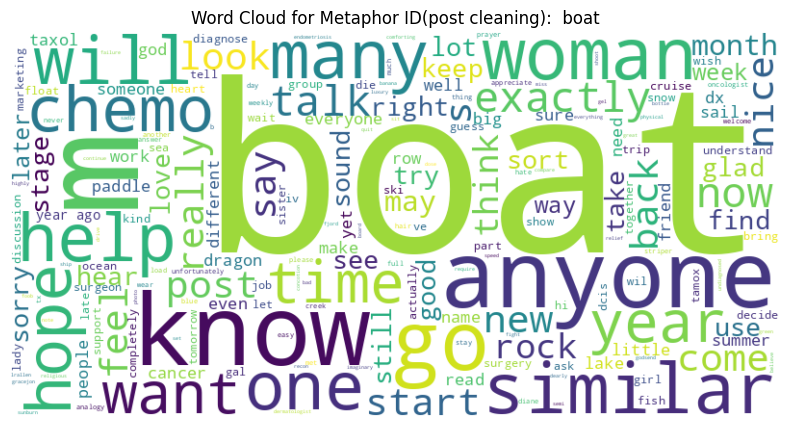

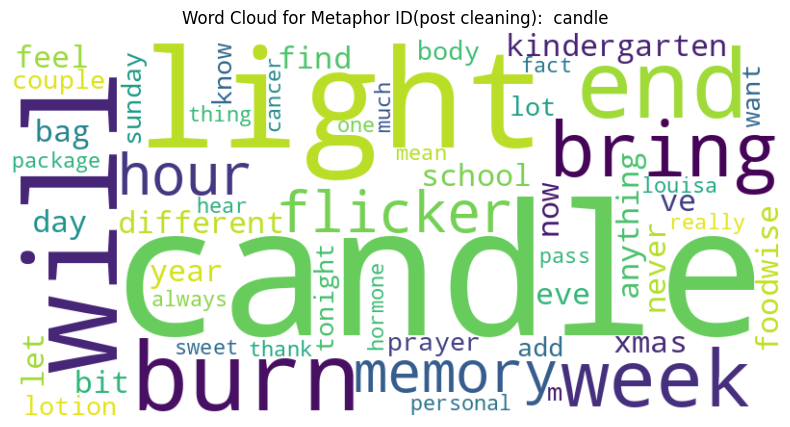

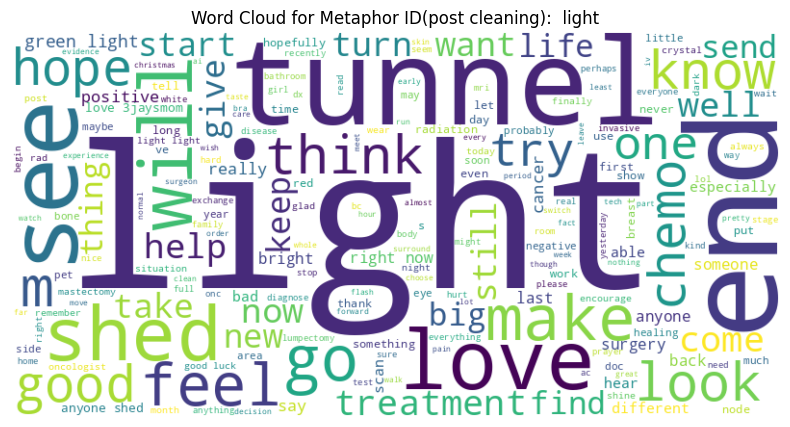

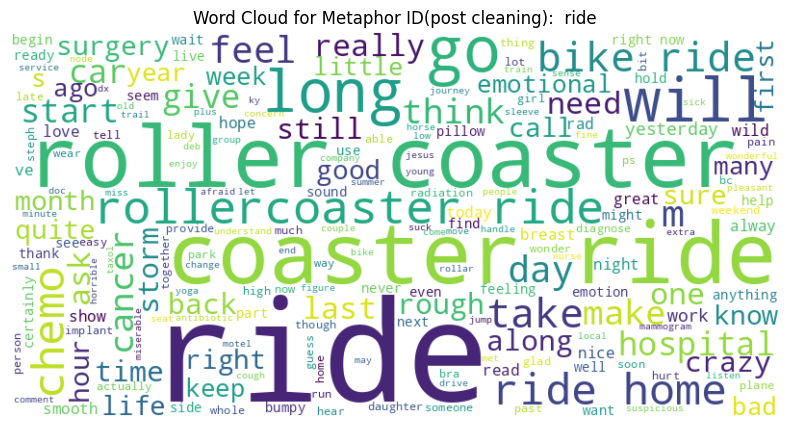

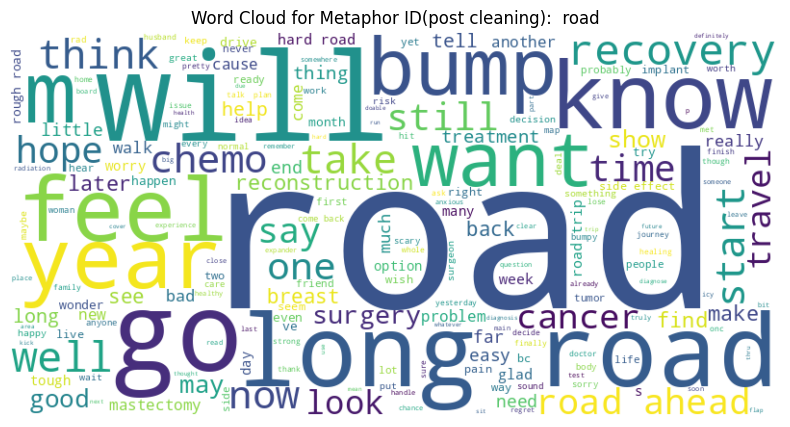

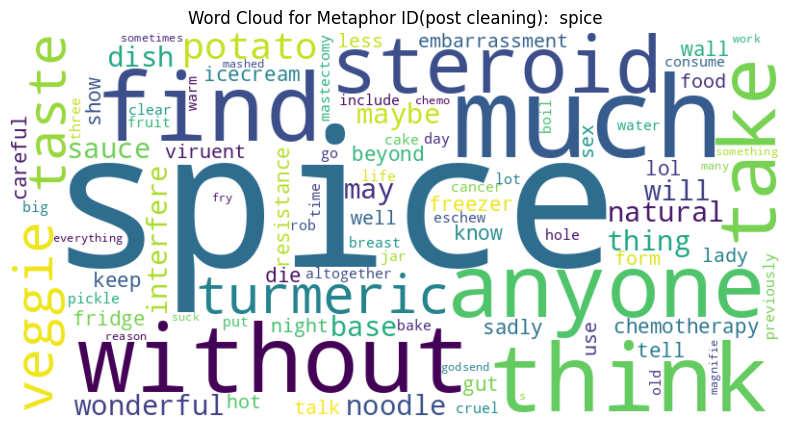

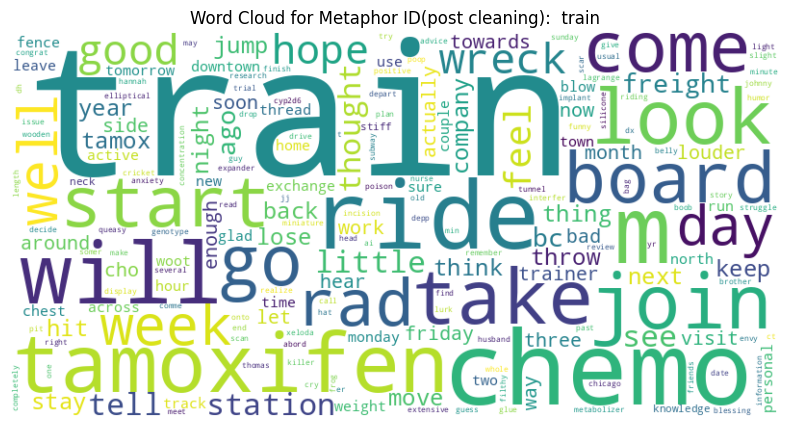

In [12]:

# Group the data by metaphorID
grouped_data_2 = cleaned_df.groupby('metaphor')['text'].apply(lambda x: ' '.join(x))

# Loop through each metaphorID and generate a word cloud
for metaphor, text in grouped_data_2.items():
    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Display the generated image:
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for Metaphor ID(post cleaning):  {metaphor}")
    plt.show()

In [13]:
X, y = cleaned_df.drop("target", axis = 1), data["label"]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [15]:
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [16]:
X_train

text metaphor
0                               this have be some ride      ride
1      my husband just leave for his road trip to or...     road
2      do your community have dial a ride ? you call...     ride
3      I be so confused so perhaps someone could she...    light
4              be all of you glad you go down this road     road
...                                                 ...      ...
1491          i have be on rollercoaster ride since aug     ride
1492                    so glad you get the green light    light
1493   I hope I be finally on the right road to reco...     road
1494   he say the outcome would be the same 5 to 10 ...     road
1495   it sound like those of you that have mastecto...     road

[1496 rows x 2 columns]

In [17]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Dense, Masking, SimpleRNN, StackedRNNCells, GRU
from tensorflow.keras.optimizers import Adam

vocab_size = 3500
embedding_dim = 16
max_length = 300 # almost all the texts are within 300 words
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [18]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train['text'])

word_index = tokenizer.word_index

In [19]:
word_index

{'<OOV>': 1,
 'the': 2,
 'i': 3,
 'be': 4,
 'and': 5,
 'a': 6,
 'to': 7,
 'road': 8,
 'of': 9,
 'light': 10,
 'have': 11,
 'in': 12,
 'on': 13,
 'it': 14,
 'you': 15,
 'that': 16,
 'this': 17,
 'down': 18,
 'ride': 19,
 'for': 20,
 'my': 21,
 'not': 22,
 'do': 23,
 'boat': 24,
 'but': 25,
 'at': 26,
 'with': 27,
 'we': 28,
 'so': 29,
 'get': 30,
 "'": 31,
 'same': 32,
 'will': 33,
 'all': 34,
 'can': 35,
 'end': 36,
 'go': 37,
 'there': 38,
 'm': 39,
 'just': 40,
 'as': 41,
 'your': 42,
 'long': 43,
 'know': 44,
 'tunnel': 45,
 'like': 46,
 'they': 47,
 'if': 48,
 'see': 49,
 'feel': 50,
 'out': 51,
 'would': 52,
 'up': 53,
 'from': 54,
 'train': 55,
 'some': 56,
 'chemo': 57,
 'about': 58,
 'year': 59,
 'what': 60,
 'she': 61,
 'take': 62,
 'think': 63,
 'or': 64,
 'now': 65,
 'good': 66,
 'one': 67,
 'love': 68,
 'when': 69,
 'start': 70,
 'look': 71,
 'make': 72,
 'want': 73,
 'he': 74,
 'hope': 75,
 'well': 76,
 'other': 77,
 'then': 78,
 'back': 79,
 "''": 80,
 'coaster': 81,
 'ca

In [20]:
training_seq = tokenizer.texts_to_sequences(X_train['text'])
training_padded = pad_sequences(training_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_seq = tokenizer.texts_to_sequences(X_test['text'])
testing_padded = pad_sequences(testing_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [21]:
testing_padded

array([[ 81,  19,   0, ...,   0,   0,   0],
       [139,  10,  51, ...,   0,   0,   0],
       [218,  18,   2, ...,   0,   0,   0],
       ...,
       [143, 675,   3, ...,   0,   0,   0],
       [  6, 823, 266, ...,   0,   0,   0],
       [ 16,  47,  78, ...,   0,   0,   0]], dtype=int32)

In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Masking, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.model_selection import train_test_split

# Define the model with additional regularization and dropout layers
model_LSTM = tf.keras.Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=300),
    Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01))),
    Dropout(0.3),  # Dropout to reduce overfitting
    Bidirectional(LSTM(64, kernel_regularizer=l2(0.01))),
    Dropout(0.3),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model with a reduced learning rate
optimizer = Adam(learning_rate=0.0005)  # Reduced learning rate for better generalization
model_LSTM.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Define early stopping and model checkpoint callbacks to monitor 'val_loss' instead of 'val_accuracy'
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Convert data to numpy arrays
training_padded = np.array(training_padded)
training_labels = np.array(y_train)
testing_padded = np.array(testing_padded)
testing_labels = np.array(y_test)

# Split training data to create a separate validation set
training_padded, validation_padded, training_labels, validation_labels = train_test_split(
    training_padded, training_labels, test_size=0.2, random_state=42
)

# Fit the model using the training and validation sets
num_epochs = 150
history = model_LSTM.fit(
    training_padded, training_labels,
    epochs=num_epochs,
    validation_data=(validation_padded, validation_labels),
    verbose=1,
    callbacks=[early_stopping, model_checkpoint]
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.7462 - loss: 6.8657 - val_accuracy: 0.7800 - val_loss: 4.7442
Epoch 2/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.7581 - loss: 4.2618 - val_accuracy: 0.7800 - val_loss: 2.9956
Epoch 3/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7577 - loss: 2.7249 - val_accuracy: 0.7800 - val_loss: 1.9520
Epoch 4/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.7552 - loss: 1.8187 - val_accuracy: 0.7800 - val_loss: 1.3459
Epoch 5/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7630 - loss: 1.2684 - val_accuracy: 0.7800 - val_loss: 1.0012
Epoch 6/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7776 - loss: 0.9339 - val_accuracy: 0.8300 - val_loss: 0.7726
Epoch 7/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.8172 - loss: 0.6816 - val_accuracy: 0.7833 - val_loss: 0.6273
Epoch 8/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8692 - loss: 0.5406 - val_accuracy: 0

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Masking
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)

# Define model checkpoint callback
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)

model_LSTM.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.0015),metrics=['accuracy'])
num_epochs = 150
training_padded = np.array(training_padded)
training_labels = np.array(y_train)
testing_padded = np.array(testing_padded)
testing_labels = np.array(y_test)

history = model_LSTM.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=1,callbacks=[early_stopping, model_checkpoint])

Epoch 1/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.7147 - loss: 0.6011 - val_accuracy: 0.7647 - val_loss: 0.5180
Epoch 2/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7724 - loss: 0.5623 - val_accuracy: 0.7647 - val_loss: 0.5584
Epoch 3/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7527 - loss: 0.5273 - val_accuracy: 0.7647 - val_loss: 0.4732
Epoch 4/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7919 - loss: 0.3904 - val_accuracy: 0.8128 - val_loss: 0.3680
Epoch 5/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9034 - loss: 0.2322 - val_accuracy: 0.8663 - val_loss: 0.3742
Epoch 6/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9506 - loss: 0.1294 - val_accuracy: 0.8316 - val_loss: 0.4480
Epoch 7/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9734 - loss: 0.0854 - val_accuracy: 0.8556 - val_loss: 0.4684
Epoch 8/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9856 - loss: 0.0544 - val_accuracy: 0.

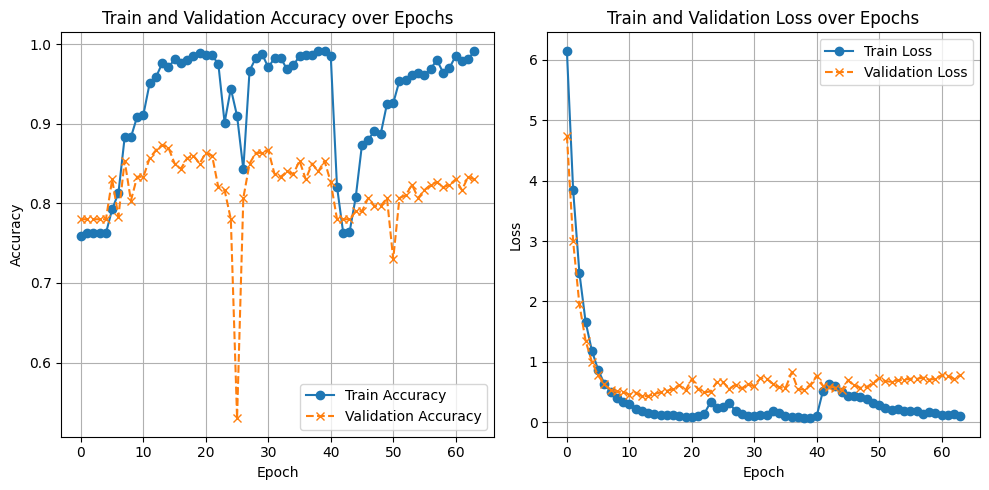

In [23]:
import matplotlib.pyplot as plt

# Assuming 'history' is the history object returned by model.fit()

# Create a figure with subplots
plt.figure(figsize=(10, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linestyle='-', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--', marker='x')
plt.title('Train and Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', linestyle='-', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--', marker='x')
plt.title('Train and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


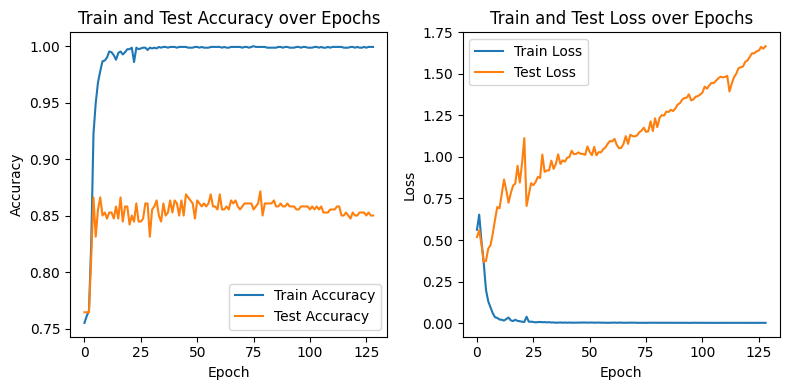

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' is the history object returned by model.fit()

# Plot training and test accuracy
plt.figure(figsize=(8, 4))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Train and Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot epoch vs loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Train and Test Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
y_pred=np.round(model_LSTM.predict(testing_padded))
y_pred=y_pred.flatten()
y_pred

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


array([1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
       1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1.,
       0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0.,
       1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1.,
       1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [26]:
from sklearn.metrics import classification_report
# Generate classification report
report = classification_report( testing_labels,y_pred)

# Print the classification report
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.76      0.74        88
           1       0.93      0.91      0.92       286

    accuracy                           0.87       374
   macro avg       0.82      0.83      0.83       374
weighted avg       0.88      0.87      0.87       374

